In [1]:
!pip install subword-nmt evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 3.8 MB/s eta 0:00:00


In [4]:
from IPython.display import clear_output
from tqdm import tqdm, trange
import numpy as np
import pandas as pd

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
from nltk.translate.bleu_score import corpus_bleu
from sklearn.model_selection import train_test_split
from vocab import Vocab
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ExponentialLR
from transformers import DataCollatorForSeq2Seq, AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

import datasets
import evaluate

import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
train_ds = pd.read_csv('/kaggle/input/hataton/HSE Data Science Hack /train.csv').drop('Unnamed: 0', axis=1)

In [6]:
train_ds

,sentence,1category,2category,sentiment
0,При этом всегда получал качественные услуги.,Communication,NaN,+
1,"Не вижу, за что хотя бы 2 поставить, сервис на 1!",?,NaN,−
2,"Вот так ""Мой любимый"" банк МКБ меня обманул.",?,NaN,−
3,Отвратительное отношение к клиентам.,Communication,NaN,−
4,"Всегда в любое время дня и ночи помогут, ответ...",Communication,NaN,+
...,...,...,...,...
19356,Никогда и ни в коем случае не открывайте счет ...,Communication,NaN,−
19357,ТИ откровенно забили на качество и развивают с...,Quality,NaN,−
19358,"Я считаю, это прорыв и лидерство финансовых ус...",?,NaN,+
19359,"Писал мужчина очень доходчиво, не финансовым я...",Communication,NaN,+


In [7]:
tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

with open('data.txt', 'w') as f:
    for line in train_ds['sentence']:
        f.write(tokenize(line) + '\n')

In [8]:
# строим и применяем bpe кодирование
learn_bpe(open('data.txt', encoding='utf-8'), open('bpe_rules', 'w', encoding='utf-8'), num_symbols=8000)
bpe = BPE(open('./bpe_rules', encoding='utf-8'))

with open('train.bpe', 'w', encoding='utf-8') as f_out:
    for line in open('data.txt', encoding='utf-8'):
        f_out.write(bpe.process_line(line.strip()) + '\n')

100%|██████████| 8000/8000 [00:10<00:00, 742.26it/s] 


In [9]:
data = np.array(open('./train.bpe', encoding='utf-8').read().split('\n'))[:-1]

In [10]:
data = data[:, np.newaxis]
target = train_ds['sentiment'].map(lambda x: -1 if x == '−' else (1 if x == '+' else 0)).to_numpy()[:, np.newaxis]

In [11]:
data = np.concatenate((data, target), axis=1)

In [12]:
train_inp, dev_inp, train_target, dev_target = train_test_split(data[:, 0], data[:, 1].astype(int), test_size=3000,
                                                          random_state=42)

In [13]:
inp_voc = Vocab.from_lines(train_inp)

In [14]:
# тут можно посмотреть, как работает мапинг из индекса в токен и наоборот
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['считаю это обманом потребителей', 'спасибо ей за профессионализм .', 'считаю это обманом потребителей', 'считаю это обманом потребителей', '- это же очень удобно и быстро !']

words to ids (0 = bos, 1 = eos):
tensor([[   0, 6771, 7737, 3968, 5171,    1,    1,    1,    1,    1],
        [   0, 6499, 1867, 2037, 5551,   67,    1,    1,    1,    1],
        [   0, 6771, 7737, 3968, 5171,    1,    1,    1,    1,    1],
        [   0, 6771, 7737, 3968, 5171,    1,    1,    1,    1,    1],
        [   0,   62, 7737, 2001, 4535, 7077, 2309,  819,    3,    1]])

back to words
['считаю это обманом потребителей', 'спасибо ей за профессионализм .', 'считаю это обманом потребителей', 'считаю это обманом потребителей', '- это же очень удобно и быстро !']


In [15]:
class BaseModel(nn.Module):
    def __init__(self, inp_voc, emb_size=64, hid_size=128):
        """
        Базовая модель encoder-decoder архитектуры
        """
        super().__init__() 

        self.inp_voc = inp_voc
        self.hid_size = hid_size
        
        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.fc = nn.Linear(hid_size, 3)
        
    def forward(self, inp):
        """ Сначала примените  encode а затем decode"""
        ans = self.encode(inp)
        return ans


    def encode(self, inp, **flags):
        """
        Считаем скрытое состояние, которое будет начальным для decode
        :param inp: матрица входных токенов
        :returns: скрытое представление с которого будет начинаться decode
        """
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]
        
        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)
        # enc_seq: [batch, time, hid_size], last_state: [batch, hid_size]
        
        # последний токен, не последние на самом деле, так как мы делали pading, чтобы тексты были
        # одинакового размер, поэтому подсчитать длину исходного предложения не так уж тривиально
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]
        
        out = self.fc(last_state)
        return out

In [44]:
class Fitter(object):
    def __init__(
        self,
        model,
        opt,
        loss,
        train_dataset,
        scheduler,
        dev_inp, dev_target,
        batch_size = 32,
        sheduler_steps = 10,
        n_epochs = 10
    ):

        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.sheduler_steps = sheduler_steps

        self.opt = opt
        self.loss = loss
        self.scheduler = scheduler
        self.train_dataset = train_dataset
        self.dev = [dev_inp, dev_target]
        
        self.model.to(device)
        self.metrics = {'train_loss': [], 'dev_ROC-AUC': [] }

    def fit(self):
        # Turn on training
        self.model.train(True)
        
        # Fit
        for epoch in range(self.n_epochs):
            train_loss = 0
            for i, (inps, targets) in tqdm(enumerate(
                DataLoader(self.train_dataset, batch_size=self.batch_size,
                           collate_fn=batch_collate_fn, shuffle=True, drop_last=True)

                ), desc='Работаем Братья', total=len(self.train_dataset) // self.batch_size):
                
                targets = torch.tensor(targets, device=device)
                self.opt.zero_grad()
                pred = self.model(inps.to(device))
                loss = self.loss(pred, targets)
                loss.backward()
                self.opt.step()
                train_loss += loss.item()
            
            if epoch % self.sheduler_steps == 1:
                self.scheduler.step()
            
            clear_output(wait=True)  
            self.model.eval()
            with torch.no_grad():
                self.metrics['train_loss'] += [train_loss / (i+1)]
                preds = F.softmax(self.model(self.model.inp_voc.to_matrix(self.dev[0]).to(device)), dim=1).detach().cpu().numpy()
                self.metrics['dev_ROC-AUC'] += [roc_auc_score(self.dev[1],
                                                              preds,
                                                              multi_class='ovr')]
                
            if len(self.metrics['dev_ROC-AUC']) > 2 and self.metrics['dev_ROC-AUC'][-1] > self.metrics['dev_ROC-AUC'][-2]:
                torch.save(self.model, 'rnn_segm.pt')
            
            plt.figure(figsize=(10, 5))
            
            plt.subplot(1, 2, 1)
            plt.xlabel("Iteration")
            plt.ylabel("Train Loss")
            plt.grid()
            plt.plot(self.metrics['train_loss'])

            plt.subplot(1, 2, 2)
            plt.xlabel("Iteration")
            plt.ylabel("ROC-AUC")
            plt.plot(self.metrics['dev_ROC-AUC'], color="orange")
            plt.grid()
            
            plt.show()
            
            self.model.train(True)
            
        # Turn off training
        self.model.train(False)

In [45]:
class MyDataset(Dataset): 
    def __init__(self, inp, target):
        self.inp = inp
        self.target = target
        
        self.inp_voc = Vocab.from_lines(self.inp)
        
    def __len__(self):
        return len(self.inp)
        
    def __getitem__(self, idx):
        return self.inp[idx], int(self.target[idx])

def batch_collate_fn(batch):
    inps = [item[0] for item in batch]
    labels = np.array([item[1] + 1 for item in batch])
    out = np.zeros((len(labels), 3))
    out[np.arange(len(labels)), labels] = 1
    return train_dataset.inp_voc.to_matrix(inps), out

In [46]:
model = BaseModel(inp_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = ExponentialLR(opt, gamma=0.9)
train_dataset = MyDataset(train_inp, train_target)
loss = nn.CrossEntropyLoss()
batch_size = 2
sheduler_steps = 1

epochs = 15

fitter =  Fitter(
                model,
                opt,
                loss,
                train_dataset,
                scheduler,
                dev_inp, dev_target,
                batch_size = batch_size,
                sheduler_steps = sheduler_steps,
                n_epochs = epochs,
)

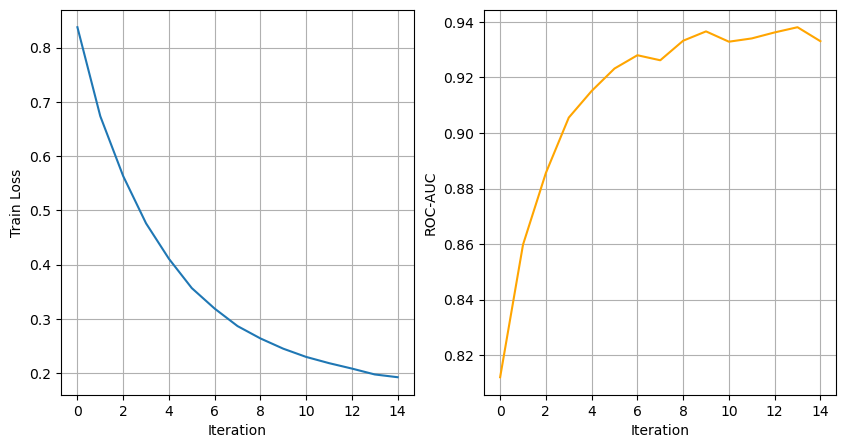

In [47]:
fitter.fit()